In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from scipy import stats
import numpy as np
import textwrap
import random 
import cv2
import os
import shutil
import warnings

warnings.filterwarnings('ignore')

In [2]:
finetune_df_merged = pd.read_csv("results/data/finetune_data_probs.csv")
pretrain_df_merged = pd.read_csv("results/data/pretrain_data_probs.csv")

finetune_df_merged.drop_duplicates(inplace=True)
pretrain_df_merged.drop_duplicates(inplace=True)

In [3]:
finetune_df_merged.reset_index(drop=True, inplace=True)
pretrain_df_merged.reset_index(drop=True, inplace=True)

In [4]:
finetune_df_merged["full_lora_abs_diff"] = np.abs(finetune_df_merged["full_lora_diff"])
pretrain_df_merged["full_lora_abs_diff"] = np.abs(pretrain_df_merged["full_lora_diff"])

In [5]:
# Function to bin a variable in the dataframe
def bin_var(df, var, abs=True, n=4):
    var_vals = df[var]
    if abs:
        var_vals = np.abs(var_vals)

    percentiles_at = np.linspace(0, 1, n+1)

    bins = list(var_vals.quantile(percentiles_at))
    labels = [f"Q{i+1}: {round(bins[i], 3)}-{round(bins[i+1], 3)}" for i in range(len(bins)-1)]
    df[f"{var}_bins"] = pd.cut(var_vals, bins=bins, labels=labels, include_lowest=True)
    return df

In [6]:
finetune_df_merged = bin_var(finetune_df_merged, var="full_lora_diff", abs=True, n=10)
pretrain_df_merged = bin_var(pretrain_df_merged, var="full_lora_diff", abs=True, n=10)

In [7]:
tot_ft_tkn_count = len(finetune_df_merged)
tot_pt_tkn_count = len(pretrain_df_merged)

ft_prob = finetune_df_merged["curr_token_freq"] / tot_ft_tkn_count
pt_prob = finetune_df_merged["pt_curr_token_freq"] / tot_pt_tkn_count

finetune_df_merged["rel_prev"] = round(ft_prob - pt_prob, 3)

In [8]:
# Sample n points from both datasets to get less crowded plots
n = 50000
pretrain_sample = pretrain_df_merged.loc[random.sample(range(len(pretrain_df_merged)), n)]
finetune_sample = finetune_df_merged.loc[random.sample(range(len(finetune_df_merged)), n)]

## Plotting relationship between full and lora

In [9]:
def scatterplot(df, x, y, xlabel=r"$PMI(w_i|w_{1:i-1})$", ylabel=r"$p_{full} - p_{lora}$", legend_title="Token probability of base model", save_path=None, hue="base_prob"):
    ax = sns.scatterplot(df, x=x, y=y, hue=hue, s=5, linewidth=0)
    wrapped_title = textwrap.fill(legend_title, width=18)
    ax.legend(title=legend_title, bbox_to_anchor=(1, 1))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [10]:
def plot_ft_div_all_feats(df, save_path): 
    f, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    sns.scatterplot(df, x="lora_base_diff", y="full_base_diff", hue="base_prob", s=5, linewidth=0, ax=axes[0])
    sns.scatterplot(df, x="lora_base_diff", y="full_base_diff", hue="pmi", s=5, linewidth=0, ax=axes[1])
    sns.scatterplot(df, x="lora_base_diff", y="full_base_diff", hue="curr_token_freq", s=5, linewidth=0, ax=axes[2])
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

In [11]:
def base_divergence(df, hue, diag, legend_title, plt_title=None, ax=None, save_path=None):
    # sns.jointplot(data=pretrain_df, x="pmi", y="base_lora_diff", alpha=0.5, s=5, linewidth=0, hue="base_prob_bin")
    scatter = sns.scatterplot(df, x="full_base_diff", y="lora_base_diff", hue=hue, s=5, linewidth=0, ax=ax)
    showplot = False
    if ax is None:
        ax = scatter
        showplot = True
    title=legend_title
    wrapped_title = textwrap.fill(title, width=18)
    ax.legend(title=wrapped_title, bbox_to_anchor=(1, 1))
    
    #Plot line along diagonal where p_full == p_lora
    if diag:
        ax.plot([-1, 1], [-1, 1], linestyle="dashed", color='r', linewidth=0.8)
    ax.set_xlabel(r"$p_{full} - p_{base}$")
    ax.set_ylabel(r'$p_{lora} - p_{base}$')
    ax.set_title(plt_title)
    if plt_title is not None: 
        ax.set_title(plt_title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

    if showplot:
        plt.show()

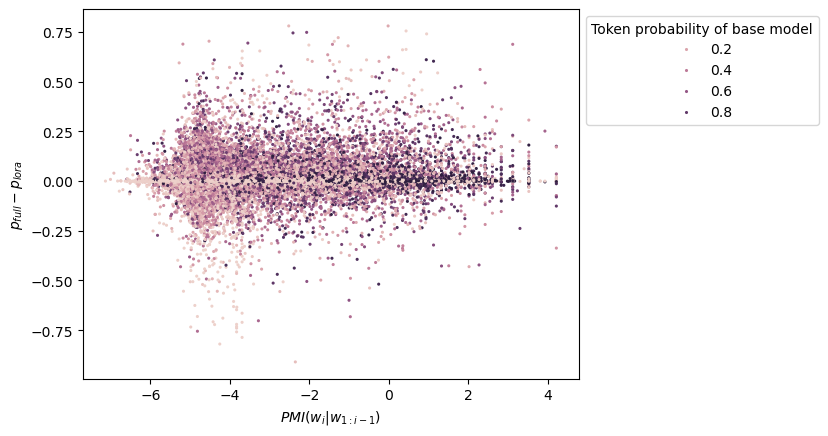

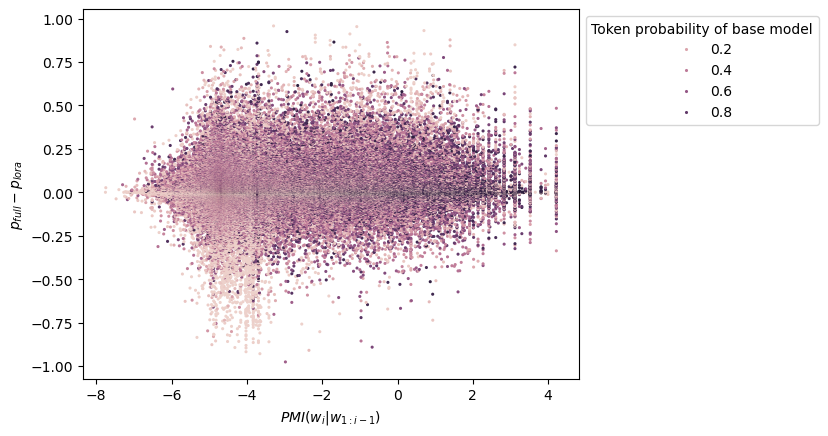

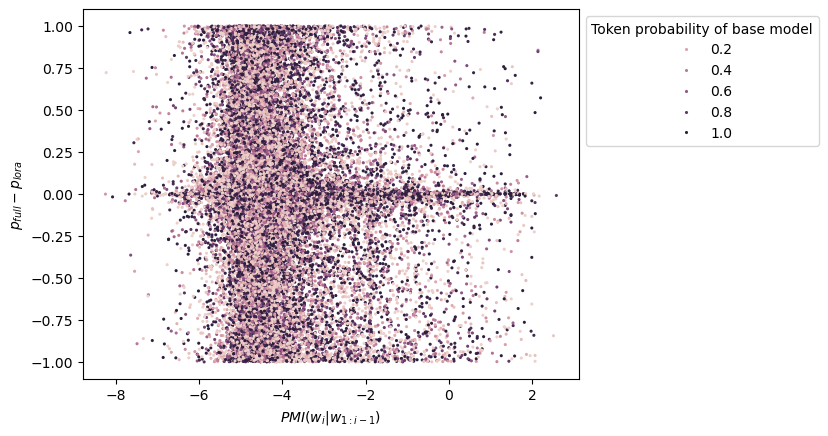

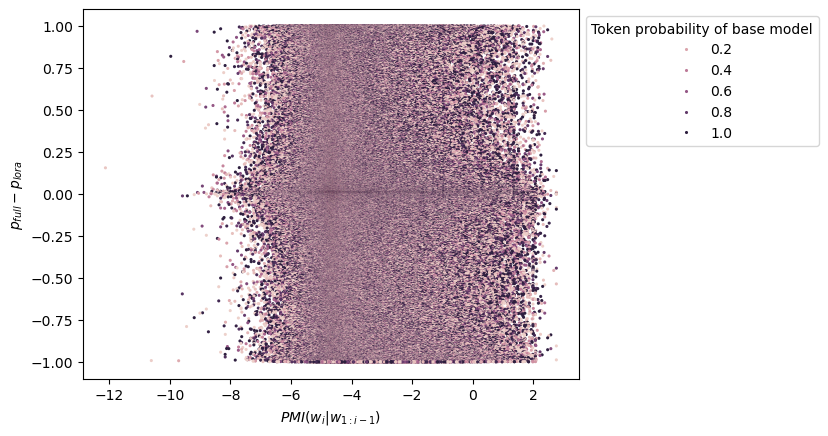

In [12]:
scatterplot(finetune_sample, x="pmi", y="full_lora_diff", save_path="results/plots/finetuning/sampled/full_lora_diff.png")
scatterplot(finetune_df_merged, x="pmi", y="full_lora_diff", save_path="results/plots/finetuning/full/full_lora_diff.png")
scatterplot(pretrain_sample, x="pmi", y="full_lora_diff", save_path="results/plots/pretraining/sampled/full_lora_diff.png")
scatterplot(pretrain_df_merged, x="pmi", y="full_lora_diff", save_path="results/plots/pretraining/full/full_lora_diff.png")

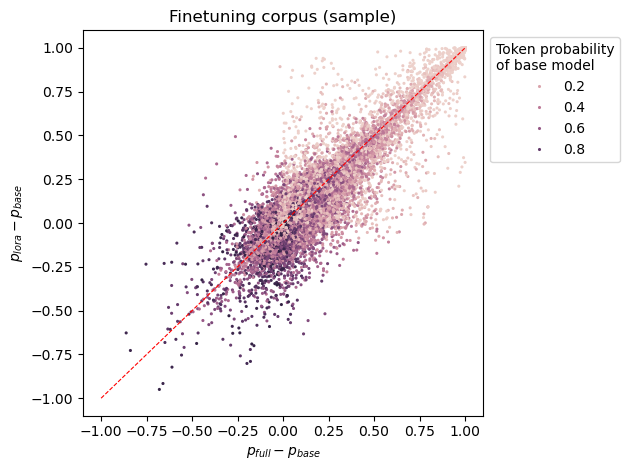

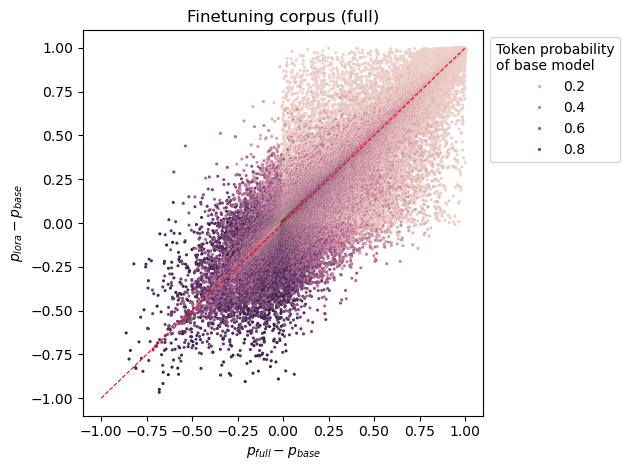

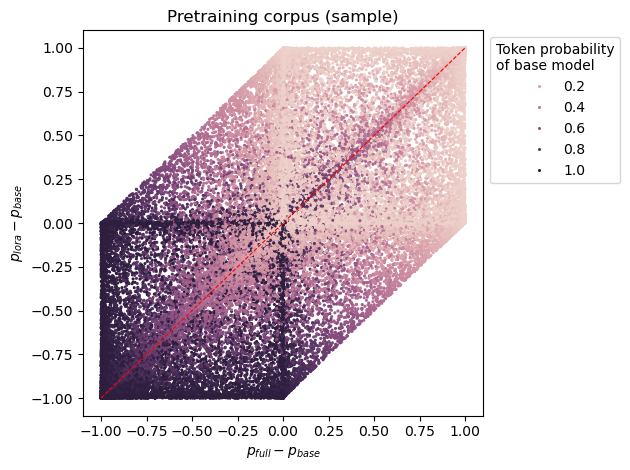

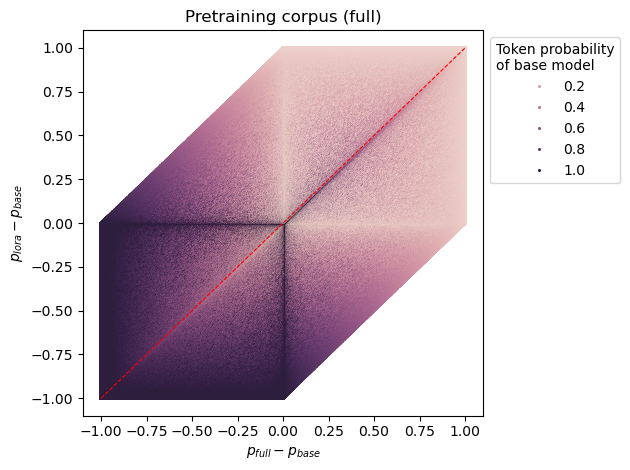

In [13]:
base_divergence(finetune_sample, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Finetuning corpus (sample)", save_path = "results/plots/finetuning/sampled/lora_vs_full_movement.png")
base_divergence(finetune_df_merged, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Finetuning corpus (full)", save_path = "results/plots/finetuning/full/lora_vs_full_movement.png")
base_divergence(pretrain_sample, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Pretraining corpus (sample)", save_path = "results/plots/pretraining/sampled/lora_vs_full_movement.png")
base_divergence(pretrain_df_merged, hue="base_prob", diag=True, legend_title="Token probability of base model", plt_title="Pretraining corpus (full)", save_path = "results/plots/pretraining/full/lora_vs_full_movement.png")

## Analysis of LoRA-FF differences 
### Attributing differences to tokens in finetuning corpus

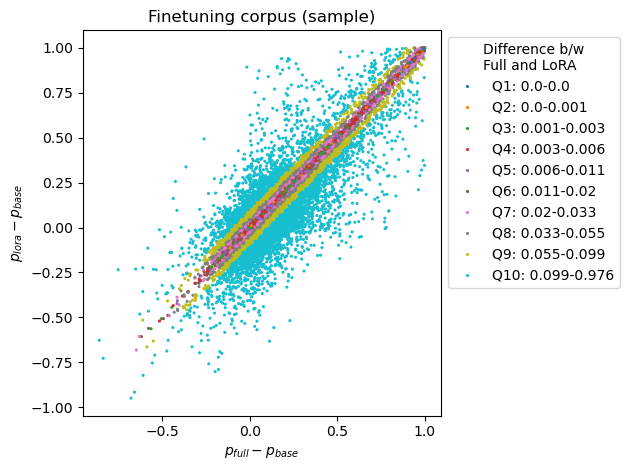

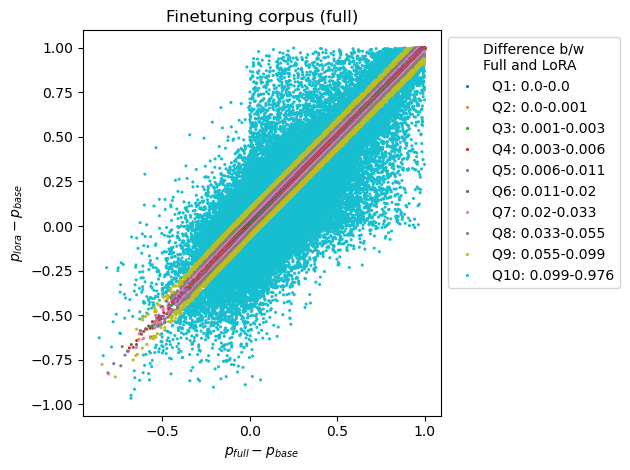

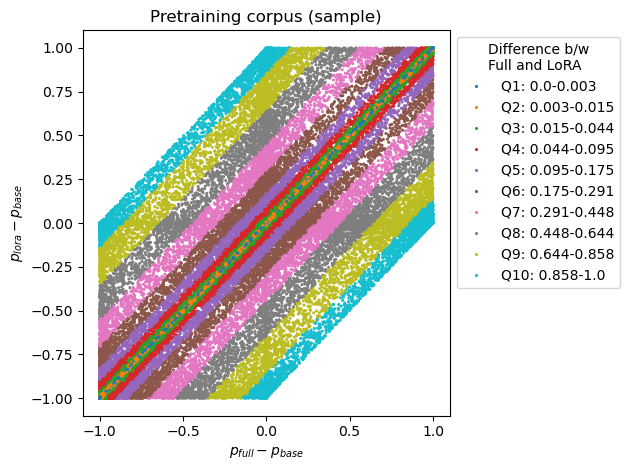

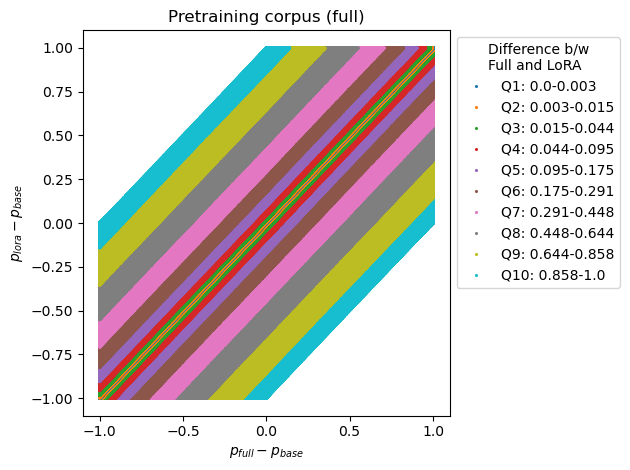

In [14]:
# Repeat above experiment but with quantiles of full_lora_diff
base_divergence(finetune_sample, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Finetuning corpus (sample)", diag=False, save_path = "results/plots/finetuning/sampled/lora_vs_full_movement_binned.png")
base_divergence(finetune_df_merged, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Finetuning corpus (full)", diag=False, save_path = "results/plots/finetuning/full/lora_vs_full_movement_binned.png")

base_divergence(pretrain_sample, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Pretraining corpus (sample)", diag=False, save_path = "results/plots/pretraining/sampled/lora_vs_full_movement_binned.png")
base_divergence(pretrain_df_merged, hue="full_lora_diff_bins", legend_title="Difference b/w Full and LoRA", plt_title="Pretraining corpus (full)", diag=False, save_path = "results/plots/pretraining/full/lora_vs_full_movement_binned.png")

In [15]:
ft_stats = finetune_df_merged.groupby('full_lora_diff_bins').describe()
pt_stats = pretrain_df_merged.groupby('full_lora_diff_bins').describe()

In [16]:
threshold = 0.0

lora_greater_threshold = finetune_df_merged[finetune_df_merged.full_lora_diff < -threshold]
full_greater_threshold = finetune_df_merged[finetune_df_merged.full_lora_diff > threshold]
full_lora_eq_threshold = finetune_df_merged[finetune_df_merged.full_lora_diff == threshold]

print("Finetuning corpus stats when p(lora) > p(full)")
stats = round(lora_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
display(stats)
print("Finetuning corpus stats when p(lora) < p(full)")
stats = round(full_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
display(stats)
print("Finetuning corpus stats when p(lora) == p(full)")
stats = round(full_lora_eq_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
display(stats)

Finetuning corpus stats when p(lora) > p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          213322.000       213322.000  213322.000
mean                0.029         4289.619       0.232
std                 0.058         7522.801       0.317
min                 0.000            1.000       0.000
25%                 0.001           35.000       0.004
50%                 0.008          246.000       0.061
75%                 0.033         4954.000       0.354
max                 0.976        26111.000       1.000

Finetuning corpus stats when p(lora) < p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          303553.000       303553.000  303553.000
mean                0.041         4310.613       0.315
std                 0.069         7504.012       0.352
min                 0.000            1.000       0.000
25%                 0.002           31.000       0.013
50%                 0.014          206.000       0.144
75%                 0.051         5363.000       0.589
max                 0.957        26111.000       1.000

Finetuning corpus stats when p(lora) == p(full)


full_lora_abs_diff  curr_token_freq  base_prob
count                 7.0            7.000      7.000
mean                  0.0         1769.429      0.835
std                   0.0         2216.092      0.369
min                   0.0            6.000      0.003
25%                   0.0          144.500      0.922
50%                   0.0          168.000      0.998
75%                   0.0         3280.000      1.000
max                   0.0         5363.000      1.000

In [17]:
threshold = 0.0
lora_greater_threshold = pretrain_df_merged[pretrain_df_merged.full_lora_diff < -threshold]
full_greater_threshold = pretrain_df_merged[pretrain_df_merged.full_lora_diff > threshold]
full_lora_eq_threshold = pretrain_df_merged[pretrain_df_merged.full_lora_diff == threshold]

stats=round(lora_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
print("Pretraining corpus stats when p(lora) > p(full)")
display(stats)

stats=round(full_greater_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
print("Pretraining corpus stats when p(lora) < p(full)")
display(stats)

stats=round(full_lora_eq_threshold[["full_lora_abs_diff", "curr_token_freq", "base_prob"]].describe(), 3)
print("Pretraining corpus stats when p(lora) == p(full)")
display(stats)

Pretraining corpus stats when p(lora) > p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          761657.000       761657.000  761657.000
mean                0.305        13862.558       0.452
std                 0.320        22564.949       0.402
min                 0.000            1.000       0.000
25%                 0.027          150.000       0.039
50%                 0.173         1502.000       0.349
75%                 0.539        21657.000       0.926
max                 1.000        72634.000       1.000

Pretraining corpus stats when p(lora) < p(full)


full_lora_abs_diff  curr_token_freq   base_prob
count          801178.000       801178.000  801178.000
mean                0.308        10164.637       0.453
std                 0.321        20854.013       0.403
min                 0.000            1.000       0.000
25%                 0.028           83.000       0.039
50%                 0.178          538.000       0.352
75%                 0.543         5064.000       0.929
max                 1.000        72634.000       1.000

Pretraining corpus stats when p(lora) == p(full)


full_lora_abs_diff  curr_token_freq  base_prob
count               287.0          287.000    287.000
mean                  0.0        19926.206      0.694
std                   0.0        16791.754      0.390
min                   0.0           16.000      0.000
25%                   0.0         5036.000      0.375
50%                   0.0        22036.000      0.962
75%                   0.0        22036.000      1.000
max                   0.0        72634.000      1.000

## Categorizing the plot into different regions 
<img src="results/figs/regions.png" alt="drawing" width="600"/>

In [18]:
def get_region(df, a, b): 
    x1, x2, y1, y2 = a[0], a[1], b[0], b[1]
    indices = (df["full_base_diff"] > x1) & (df["full_base_diff"] < x2) & (df["lora_base_diff"] < y2) & (df["lora_base_diff"] > y1)
    return df[indices]

In [19]:
# First quadrant ((lora_base_diff) > 0 and (full_base_diff > 0))

full_base_int = (0.00, 1.00)
lora_base_int = (0.00, 1.00)

first_quad = get_region(finetune_df_merged, full_base_int, lora_base_int)

# r1
full_base_int = (0.00, 0.25)
lora_base_int = (0.75, 1.00)

r1 = get_region(first_quad, full_base_int, lora_base_int)
r1.to_csv("results/data/examples_r1.csv", index=False)

# r2
full_base_int = (0.75, 1.00)
lora_base_int = (0.00, 0.25)

r2 = get_region(first_quad, full_base_int, lora_base_int)
r2.to_csv("results/data/examples_r2.csv", index=False)

# r3: along diagonal 
r3 = first_quad[first_quad["full_lora_abs_diff"] < 0.001]
r3.to_csv("results/data/examples_r3.csv", index=False)

r_3a = r3[r3["full_lora_diff"] < 0.00] # above diagonal
r_3b = r3[r3["full_lora_diff"] > 0.00] # below diagonal

r_3a.to_csv("results/data/examples_r3a.csv", index=False)
r_3b.to_csv("results/data/examples_r3b.csv", index=False)

full_base_int = (-1.00, 0.00)
lora_base_int = (-1.00, 0.00)

# 4th quadrant ((lora_base_diff) < 0 and (full_base_diff < 0))

fourth_quad = get_region(finetune_df_merged, full_base_int, lora_base_int)

# r4
r4 = fourth_quad[fourth_quad["full_lora_abs_diff"] < 0.001]
r4.to_csv("results/data/examples_r4.csv", index=False)


r_4a = r4[r4["full_lora_diff"] < 0.00] # above diagonal
r_4b = r4[r4["full_lora_diff"] > 0.00] # below diagonal

r_4a.to_csv("results/data/examples_r4a.csv", index=False)
r_4b.to_csv("results/data/examples_r4b.csv", index=False)


# r5
full_base_int = (-0.75, -0.5)
lora_base_int = (-0.25, 0.00)

r5 = get_region(fourth_quad, full_base_int, lora_base_int)
r5.to_csv("results/data/examples_r5.csv", index=False)

# r6
full_base_int = (-0.25, 0.00)
lora_base_int = (-0.75, -0.5)

r6 = get_region(fourth_quad, full_base_int, lora_base_int)
r6.to_csv("results/data/examples_r6.csv", index=False)


## Exploring Relative Corpus Prevalence when $p_{lora} > p_{base}$ and $p_{full} > p_{base}$

We define the `rel_prev` feature to capture the relative prevalence of a token in the finetuning corpus as compared to its occurrence in the pretraining corpus.


(0.0, 1.0)

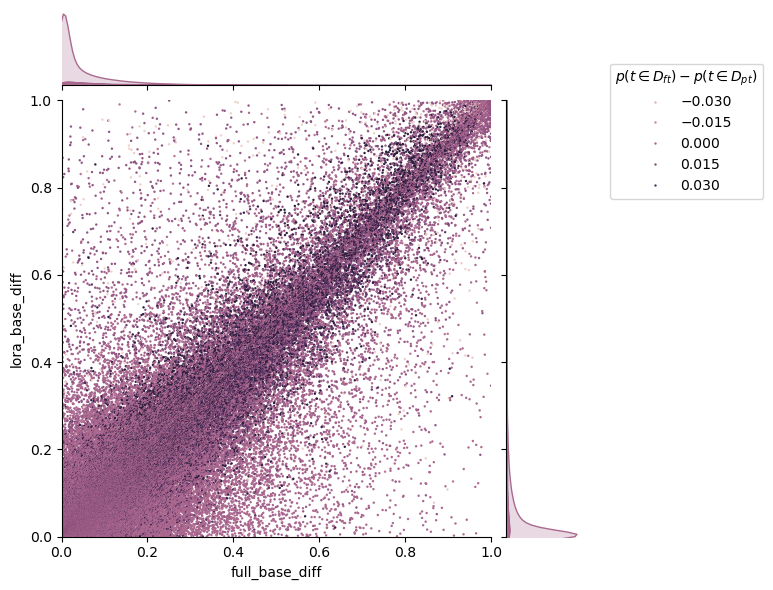

In [20]:
g = sns.jointplot(first_quad, x="full_base_diff", y="lora_base_diff", hue="rel_prev", s=3, linewidth=0)
legend = g.ax_joint.get_legend()
legend.set_loc("upper right")
legend.set_bbox_to_anchor((1.65, 1.1))
legend.set_title(r"$p(t \in D_{ft}) - p(t \in D_{pt})$")
g.ax_marg_x.set_xlim(0,1)
g.ax_marg_y.set_ylim(0,1)

In [21]:
ft_prev = first_quad[(first_quad["rel_prev"] > 0.0)]
pt_prev = first_quad[(first_quad["rel_prev"] < 0.0)]
eq_prev = first_quad[(first_quad["rel_prev"] == 0.0)]


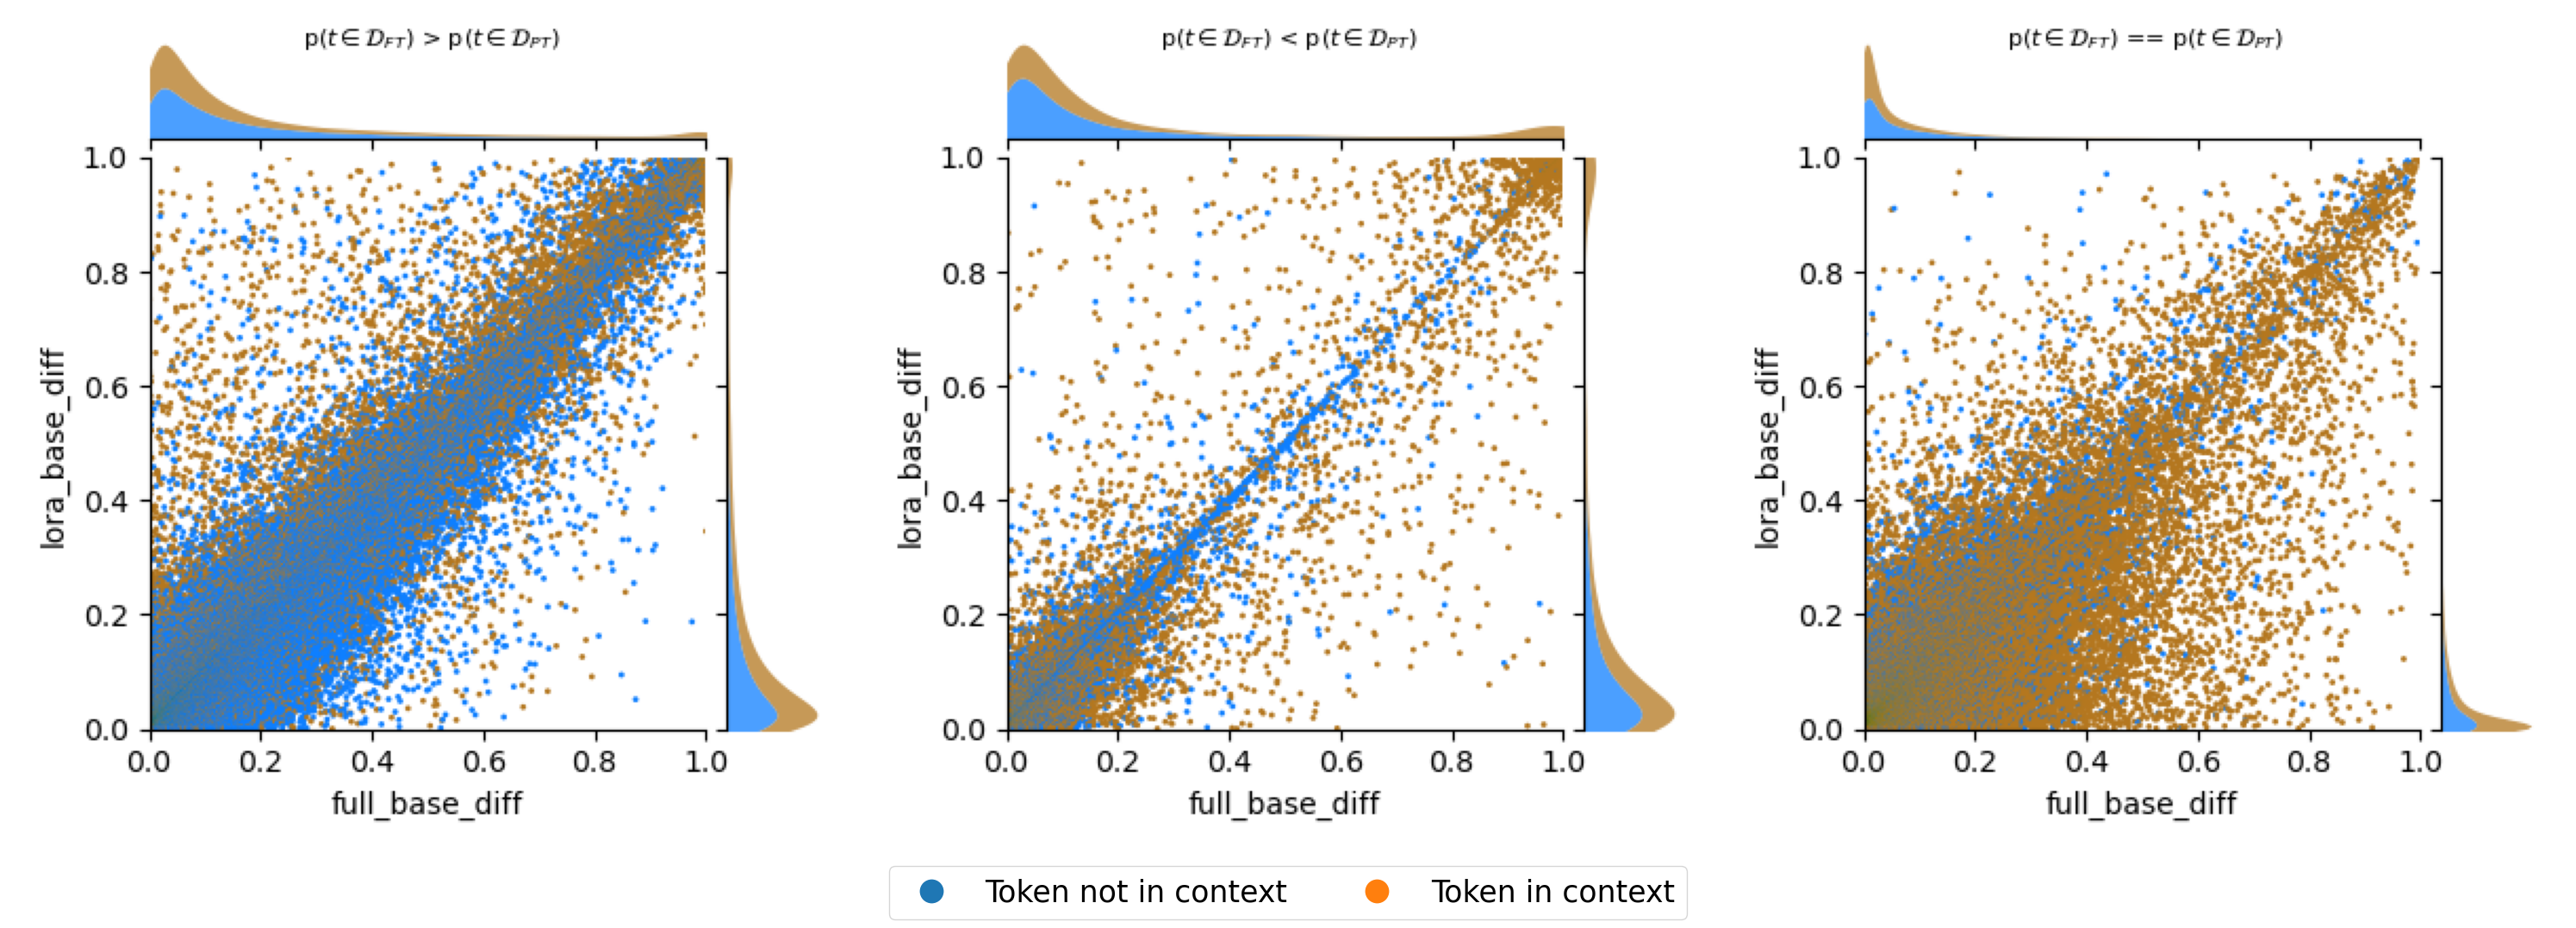

In [22]:
fig, axarr = plt.subplots(1,3, figsize=(30,90))

def create_jointplot(df, title, x="full_base_diff", y="lora_base_diff", hue="token_in_context"):

   # First subplot: JointGrid for 'total_bill' and 'tip'
   g1 = sns.JointGrid(data=df, x=x, y=y, hue=hue, height=4, dropna=True)
   g1.plot_joint(sns.scatterplot,s=4,linewidth=0)

   # g1.ax_joint.set_ylim(-0.2,1)
   g1.ax_marg_x.set_xlim(0,1)
   g1.figure.suptitle(title, fontsize=8)
   g1.ax_marg_y.set_ylim(0,1)

   g1.plot_marginals(sns.kdeplot, multiple="stack", fill=True, common_norm=False, linewidth=0)
   handles, labels = g1.ax_joint.get_legend_handles_labels()
   g1.ax_joint.legend_.remove()
   
   return plt, handles, labels

# stitch the above plots together
dfs = [ft_prev, pt_prev, eq_prev]
titles = [r"p($t \in \mathcal{D}_{FT}$) > p($t \in \mathcal{D}_{PT}$)", r"p($t \in \mathcal{D}_{FT}$) < p($t \in \mathcal{D}_{PT}$)", r"p($t \in \mathcal{D}_{FT}$) == p($t \in \mathcal{D}_{PT}$)"]
tmp_dir = "results/plots/finetuning/full/tmp"
os.makedirs(tmp_dir, exist_ok=True)
for i, df in enumerate(dfs):
   
   g, handles, labels = create_jointplot(df, title=titles[i])
   filepath=os.path.join(tmp_dir, f"image_{i}.png")
   g.savefig(filepath)
   g.close()

   im = cv2.imread(filepath)
   axarr[i].imshow(im)
   axarr[i].axis("off")


fig.legend(handles, ["Token not in context", "Token in context"], loc='lower center',bbox_to_anchor=(0.5, .435), fontsize=25, ncol=2, markerscale=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig("results/plots/finetuning/full/prevalence_plots.png", bbox_inches='tight')
shutil.rmtree(tmp_dir)


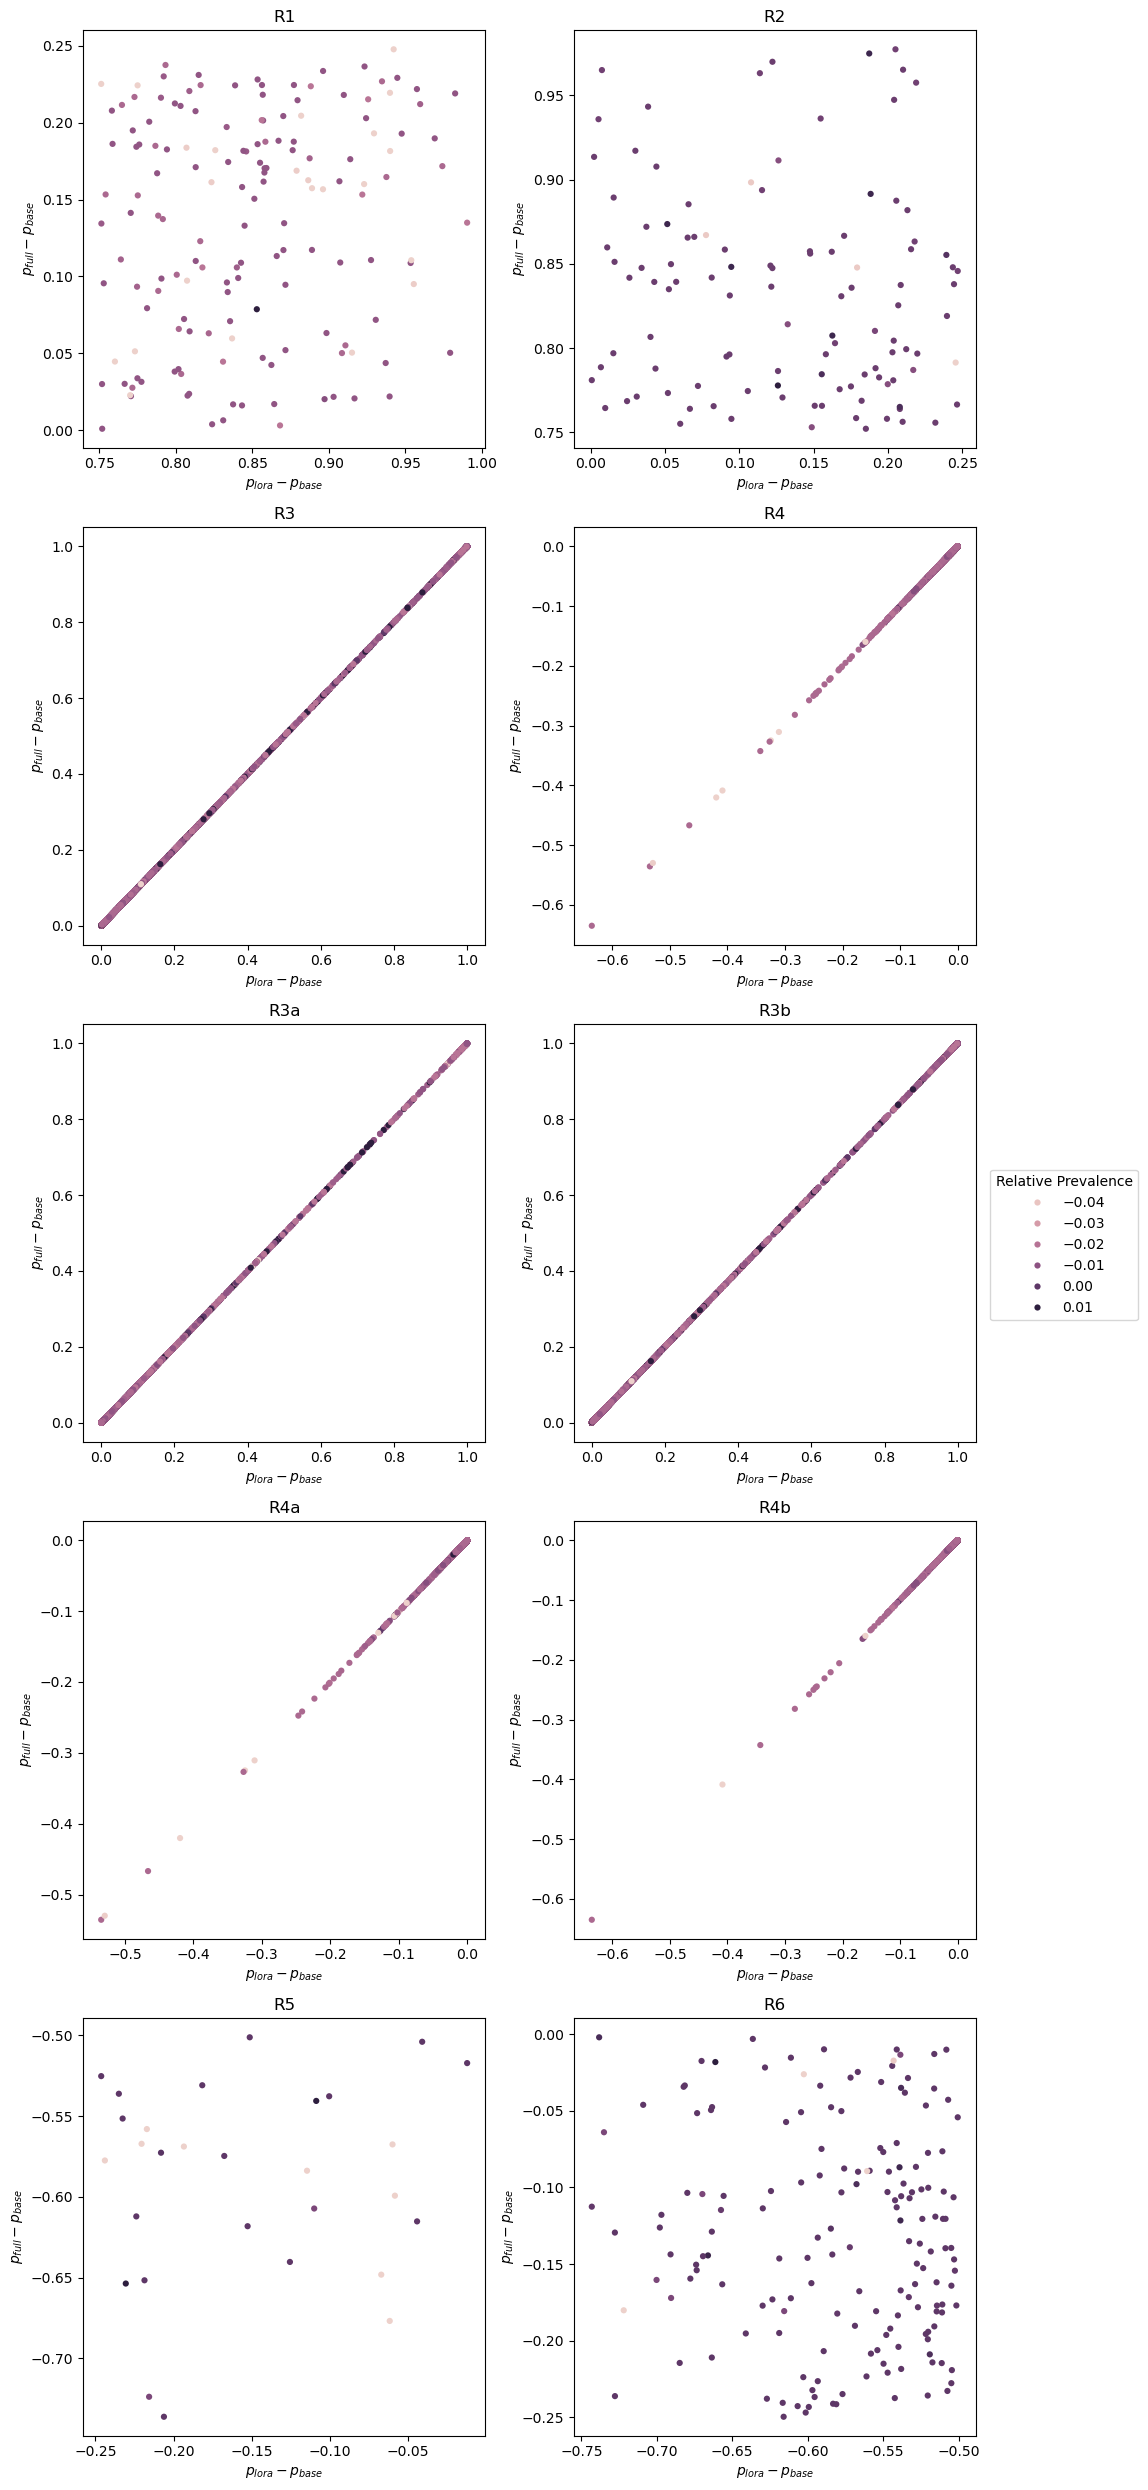

In [23]:
# Plotting the distribution of points in R1, R2, R3, R4, R5, R6 colored by rel_prev

def plot_region(region_df, region_name, ax):
    """Plot distribution of points in a region with respect to lora - base probability and full - base probability coloreed by rel_prev"""
    
    # Plot base probability distribution
    scatter = sns.scatterplot(data=region_df, x='lora_base_diff', y='full_base_diff', hue='rel_prev', ax=ax, linewidth=0, s=20)
    ax.set_title(region_name)
    ax.set_xlabel(r'$p_{lora} - p_{base}$')
    ax.set_ylabel(r'$p_{full} - p_{base}$')
    
    # Remove individual legends
    ax.get_legend().remove()

    plt.tight_layout()
    return scatter

# Create figure with 3x2 subplots
plot_grid = (5, 2)
rows, cols = plot_grid[0], plot_grid[1]
size = 5
figsize = (cols * 5, rows * 5)
fig, axs = plt.subplots(rows, cols, figsize=figsize)
region_dfs = [r1, r2, r3, r4, r_3a, r_3b, r_4a, r_4b,r5, r6]
region_names = ["R1", "R2", "R3", "R4", "R3a", "R3b", "R4a", "R4b", "R5", "R6"]

# Get the norm for consistent color scaling across all plots
all_rel_prev = pd.concat([df['rel_prev'] for df in region_dfs])
vmin, vmax = all_rel_prev.min(), all_rel_prev.max()

scatters = []
for i, region_df in enumerate(region_dfs):
    row = i // cols
    col = i % cols
    scatter = plot_region(region_df, region_names[i], axs[row, col])
    scatters.append(scatter)

# Create a single legend using the last scatter plot
handles, labels = scatters[-1].get_legend_handles_labels()
fig.legend(handles, labels, 
          loc='center right',  # Adjust location as needed
          bbox_to_anchor=(1.15, 0.5),  # Adjust position as needed
          title='Relative Prevalence',
          fontsize=10)

plt.savefig("results/plots/finetuning/full/region_plots.png", bbox_inches='tight')

### Takeaways

We consider 3 scenarios with respect to the relative prevalence: 

A. token is more likely to be present in the finetuning corpus than the pretraining corpus\
B. token is more likely to be present in the pretraining corpus than the finetuning corpus\
C. token is equally likely to be present in the pretraining corpus and finetuning corpus\

We find that the probability distribution of the divergence of full/lora from base probability remains the same for scenarios A and B (as evident in the marginal distributions), whereas when a token is equally in the 2 corpora (C), there is a higher likelihood of the divergence from base being lesser than that of A and B.

### Distribution of points

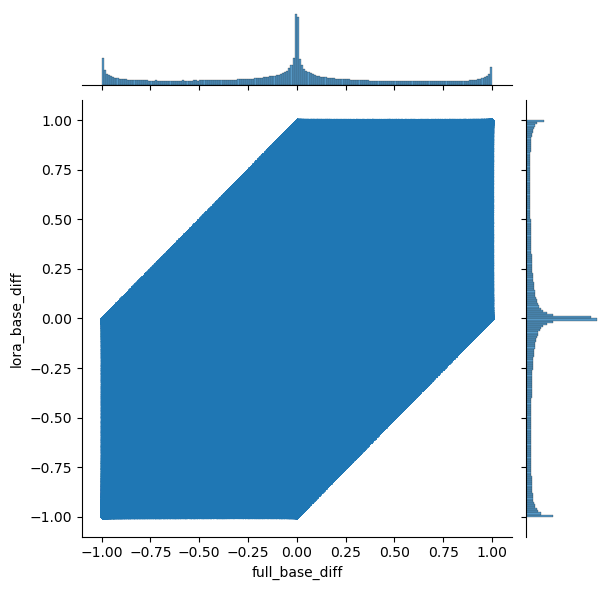

In [24]:
sns.jointplot(data=pretrain_df_merged, x="full_base_diff", y="lora_base_diff", s=5,linewidth=0)

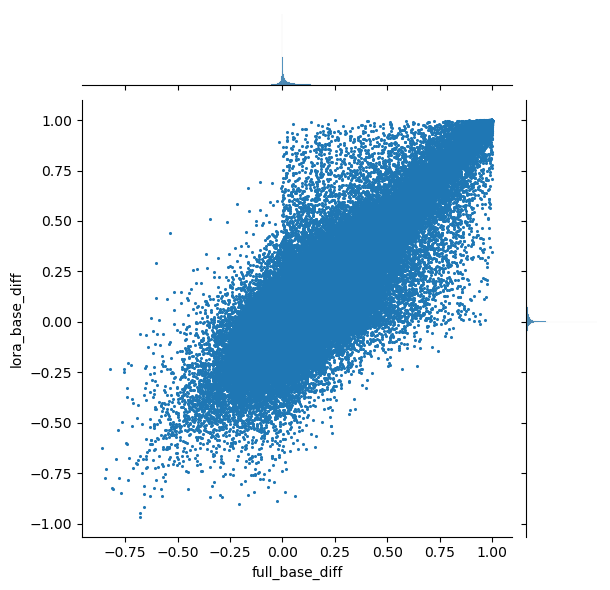

In [25]:
sns.jointplot(data=finetune_df_merged, x="full_base_diff", y="lora_base_diff", s=5,linewidth=0)

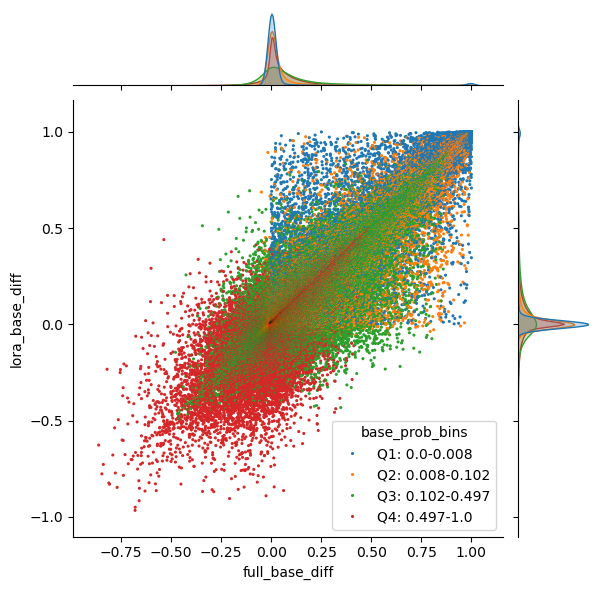

In [26]:
binned_base = bin_var(df=finetune_df_merged, var="base_prob")
sns.jointplot(data=binned_base, x="full_base_diff", y="lora_base_diff", s=5, linewidth=0, hue="base_prob_bins")

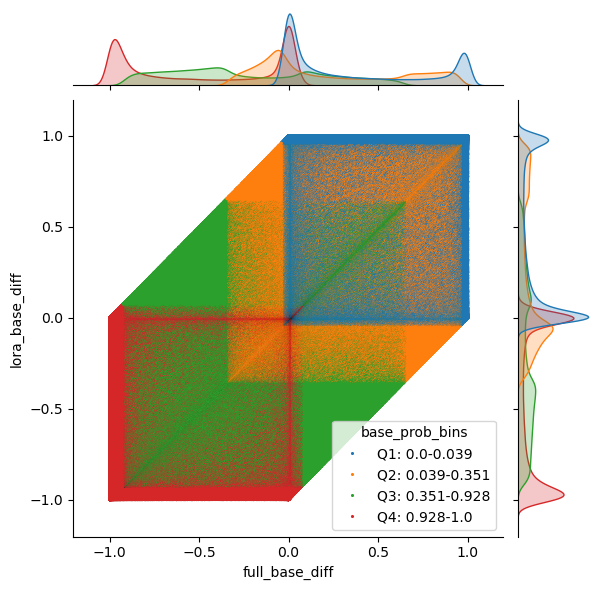

In [27]:
binned_base = bin_var(df=pretrain_df_merged, var="base_prob")
sns.jointplot(data=binned_base, x="full_base_diff", y="lora_base_diff",  s=5, linewidth=0, hue="base_prob_bins")